In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [22]:
#reading the data
data = pd.read_csv('data/all_data.csv', on_bad_lines='skip')
display(data)

,Kunde,customname,customform,name,fieldobjectid,fieldparentid,fieldparenttype,elementtype,fieldtype,blocktype,specialtype,fieldrelation,fieldlabel,language
0,abinventech,form876,876,Kundereklamation,877,878.0,customformelement,field,listselect,NaN,NaN,form2488,Vælg kunde,DA
1,abinventech,form876,876,Kundereklamation,878,NaN,customform,block,NaN,layout_fieldset,NaN,NaN,Kundeoplysninger,DA
2,abinventech,form876,876,Kundereklamation,879,878.0,customformelement,field,string,NaN,NaN,NaN,Gadenavn,DA
3,abinventech,form876,876,Kundereklamation,880,878.0,customformelement,field,string,NaN,NaN,NaN,Postnr,DA
4,abinventech,form876,876,Kundereklamation,881,878.0,customformelement,field,string,NaN,NaN,NaN,By,DA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10331,ipw,form1927875,1927875,Azure - Udløb af client secret,2610308,2592044.0,customformelement,special,NaN,NaN,createdby,NaN,Ansvarlig for opsætning,DA
10332,ipw,form1329139,1329139,Leverancer,2612534,NaN,customform,block,NaN,layout_fieldset,NaN,NaN,UDGÅET felter,DA
10333,ipw,form1329139,1329139,Leverancer,2612540,1361554.0,customformelement,special,NaN,NaN,layout_text,NaN,Installationen oprettes på domænet xxxx.ipw.dk,DA
10334,ipw,form1329139,1329139,Leverancer,2612546,1361554.0,customformelement,special,NaN,NaN,layout_text,NaN,Installationen oprettes på domænet <b>xxxx.ipw...,DA


### Grouping Field Labels and Types by ID

In this case, we will:
- Put all field labels in a list, as well as the field types.
- Group them by the form's `ID`.
- The data will be a form aggregate, containing:
  - A name
  - A list of field types
  - A list of field labels

In [23]:
# Remove all elements of type block.(maybe late include it)
indices_to_drop = data[data['elementtype'] == 'block'].index

# Drop those indices
data = data.drop(indices_to_drop)

# If the element is special the actual fieldtype is in specialtype
# We will exclude element types.

#none since logic to do it.
data['isspecial'] = data['elementtype'].apply(lambda x: 1 if x == 'special' else 0)

for index, row in data.iterrows():
    if row['isspecial'] == 1:
        if pd.notnull(row['fieldtype']):  # Check if 'fieldtype' is already filled
            print(f"Row {index}: 'fieldtype' already has a value before assigning 'specialtype'")
        else:
            # If 'fieldtype' is empty, assign the value from 'specialtype'
            data.at[index, 'fieldtype'] = row['specialtype']

#Drop non-relevant columns.
data = data.drop(columns=['Kunde','isspecial','elementtype', 'customname','fieldobjectid','fieldparentid','fieldparenttype','blocktype','fieldrelation','language','specialtype'])

#Lets group the data by customform (id) and include name and mape the structure.
grouped = data.groupby(['customform', 'name']).agg({
    'fieldtype': lambda x: list(x),  # Keep all field types as a list
    'fieldlabel': lambda x: list(x)  # Concatenate field labels
}).reset_index()

# Step 2: Count occurrences of each field type for each customform
fieldtype_counts = data.groupby(['customform', 'fieldtype']).size().unstack(fill_value=0)

# Step 3: Combine the aggregated data with the counts
result = pd.merge(grouped, fieldtype_counts, on='customform', how='left')
display(result)

,customform,name,fieldtype,fieldlabel,attachfile,autonum,autonumpre,businessunit,changed,changedby,...,riskmatrix,standards,state,string,text,texthistory,url,userrelation,userrelation_multiple,versionnumber
0,770,Projektportefølje,"[autonum, created, createdby, relation, string...","[Projekt nr., Oprettet den, Oprettet af, Proje...",0,1,0,0,0,0,...,0,0,0,1,10,0,0,3,1,0
1,775,Projektområde,[string],[Tekst],0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,876,Claims,"[userrelation, text, relation, text, createdby...","[Processor, Description of claim, Complaint ca...",0,11,0,0,0,0,...,0,0,0,112,49,2,1,15,9,0
3,876,Kundereklamation,"[listselect, string, string, string, string, s...","[Vælg kunde, Gadenavn, Postnr, By, Telefonnumm...",0,11,0,0,0,0,...,0,0,0,112,49,2,1,15,9,0
4,876,Reklamation,"[listselect, string, string, userrelation, rel...","[Vælg kunde, E-mail, Kontaktperson, Behandles ...",0,11,0,0,0,0,...,0,0,0,112,49,2,1,15,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,2584010,Formularkatalog,"[createdby, created, layout_linebreak, changed...","[Oprettet af, Oprettet, Blank linje, Seneste æ...",0,0,0,0,1,1,...,0,0,0,2,5,0,1,0,0,0
855,2584018,Formularkatalog - Kategori,[string],[Kategori],0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
856,2584251,Formularkatalog - Øvrige vurderinger,"[text, userrelation, relation, text]","[Hvad gør formularen god?, Vurderet af, Vurder...",0,0,0,0,0,0,...,0,0,0,0,2,0,0,1,0,0
857,2584255,Formularkatalog - Vurderingsskala,[integer],[Vurdering],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Word Embedding

We will create embeddings for the following:
- Name
- Field type list
- Field label list

In [24]:
 #Combine the text into a single list for Word2Vec
# Ensure all entries are strings
all_texts = [result['name'].tolist()] + result['fieldtype'].tolist() + result['fieldlabel'].tolist()

# Flatten the list of lists to a single list of strings
all_texts = [str(item) for sublist in all_texts for item in sublist]

# Tokenize the text into lists of words
tokenized_texts = [text.split() for text in all_texts]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Create Embeddings
def get_embedding(text):
    # If the input is a list, join it to form a single string
    if isinstance(text, list):
        # Convert all elements to string and filter out None or NaN values
        text = ' '.join(str(item) for item in text if pd.notna(item))
    
    # Handle case where text might still be empty after filtering
    if not text:
        return [0] * model.vector_size

    # Tokenize the text
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if len(word_vectors) == 0:  # In case no words are in the model
        return [0] * model.vector_size
    
    # Average the word vectors
    return np.mean(word_vectors, axis=0)

# Generate embeddings for each column
result['name_embedding'] = result['name'].apply(get_embedding)
result['fieldtype_embedding'] = result['fieldtype'].apply(get_embedding)
result['fieldlabel_embedding'] = result['fieldlabel'].apply(get_embedding)

# Display the results
display(result[['name', 'fieldtype', 'fieldlabel', 'name_embedding', 'fieldtype_embedding', 'fieldlabel_embedding']])

,name,fieldtype,fieldlabel,name_embedding,fieldtype_embedding,fieldlabel_embedding
0,Projektportefølje,"[autonum, created, createdby, relation, string...","[Projekt nr., Oprettet den, Oprettet af, Proje...","[0.0005039418, 0.0034946073, 0.007462857, -0.0...","[-0.0011436561, -0.00012232097, 0.004730363, -...","[-0.018516278, 0.05092508, -0.009673016, 0.023..."
1,Projektområde,[string],[Tekst],"[0.009846041, 0.0040912116, -0.004202361, -0.0...","[-0.00053622725, 0.00023643136, 0.0051033497, ...","[-0.003242764, -0.006653836, 0.00876004, 0.003..."
2,Claims,"[userrelation, text, relation, text, createdby...","[Processor, Description of claim, Complaint ca...","[-5.8569283e-05, 0.010105107, 0.0006465924, -0...","[-0.0040110005, 0.00230509, -0.00058348465, 0....","[-0.016304394, 0.0467216, -0.009150537, 0.0195..."
3,Kundereklamation,"[listselect, string, string, string, string, s...","[Vælg kunde, Gadenavn, Postnr, By, Telefonnumm...","[-0.009846088, 0.0042357175, 0.0067365943, 0.0...","[-0.0013786328, 0.0008551674, 0.0015373905, 0....","[-0.026892187, 0.07326179, -0.013489194, 0.033..."
4,Reklamation,"[listselect, string, string, userrelation, rel...","[Vælg kunde, E-mail, Kontaktperson, Behandles ...","[-0.014755713, 0.026674422, -0.0058467835, 0.0...","[-0.0022911471, 0.0017298396, 0.0017067906, 0....","[-0.028373882, 0.07891565, -0.012246838, 0.034..."
...,...,...,...,...,...,...
854,Formularkatalog,"[createdby, created, layout_linebreak, changed...","[Oprettet af, Oprettet, Blank linje, Seneste æ...","[0.0022099977, 0.01113002, -0.0045362096, 0.00...","[-0.0030258822, 0.00074607186, 0.0007428488, 0...","[-0.03170242, 0.08877563, -0.015816001, 0.0382..."
855,Formularkatalog - Kategori,[string],[Kategori],"[-0.058746397, 0.15646972, -0.027092358, 0.065...","[-0.00053622725, 0.00023643136, 0.0051033497, ...","[-0.007186147, 0.003527262, -0.0007506787, 0.0..."
856,Formularkatalog - Øvrige vurderinger,"[text, userrelation, relation, text]","[Hvad gør formularen god?, Vurderet af, Vurder...","[-0.042849604, 0.12167976, -0.023483228, 0.049...","[-0.004856549, 0.0015519282, 0.0032217035, 0.0...","[-0.019921957, 0.061571896, -0.011213157, 0.02..."
857,Formularkatalog - Vurderingsskala,[integer],[Vurdering],"[-0.054272484, 0.15865938, -0.025399223, 0.063...","[-0.0033387006, -0.006891975, 0.0064954115, 0....","[-0.006167418, 0.0015673523, -0.00779247, 0.00..."


### Dimensionality Reduction

After combining the embeddings we obtained, we will fit them to t-SNE and look for patterns and similarities.


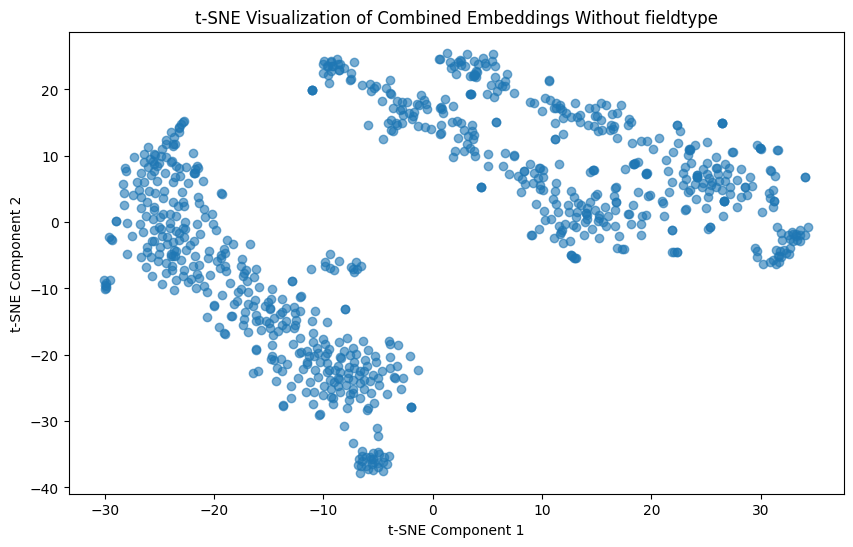

In [25]:
combined_embeddings = np.array([
    np.concatenate((row['name_embedding'], row['fieldlabel_embedding']))
    for _, row in result.iterrows()
])
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(combined_embeddings)
# Reduce the dimensionality of the combined embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(scaled_embeddings)

#Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], alpha=0.6)
plt.title('t-SNE Visualization of Combined Embeddings Without fieldtype')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [27]:
# Combine all embeddings into a single array for clustering
combined_embeddings = np.array([
    np.concatenate((row['name_embedding'], row['fieldtype_embedding'], row['fieldlabel_embedding']))
    for _, row in result.iterrows()
])

print(combined_embeddings.shape)
scaler = StandardScaler() 
scaled_embeddings = scaler.fit_transform(combined_embeddings)

(859, 300)


Result from embedding witht the fieldtypes gives a better result because we have more information about forms.

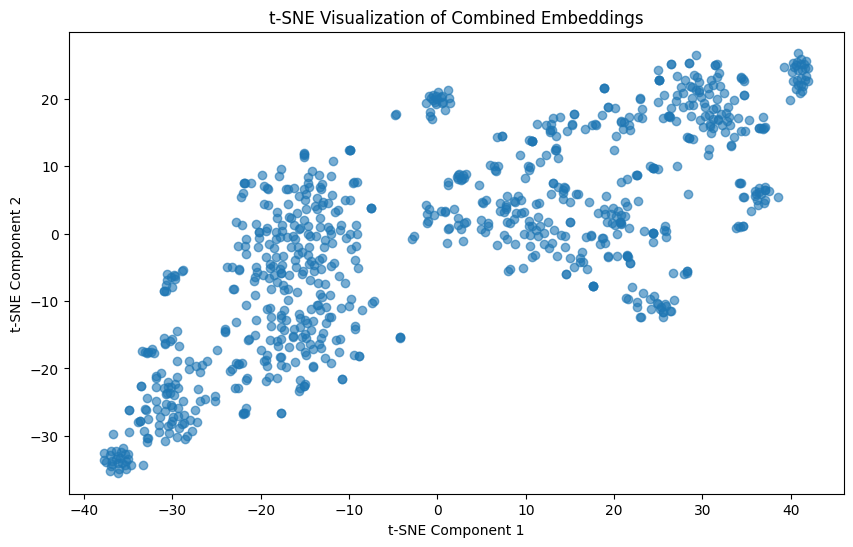

In [28]:


# Reduce the dimensionality of the combined embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(scaled_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], alpha=0.6)
plt.title('t-SNE Visualization of Combined Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


try reduce the Dimentionaity with PCA.


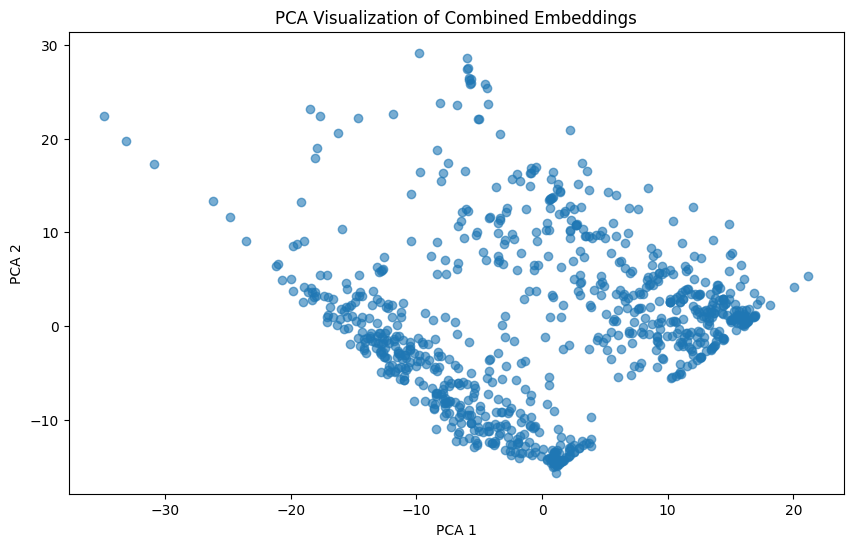

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_embeddings)

#  Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.6)
plt.title('PCA Visualization of Combined Embeddings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

After deciding using the T-sne with fieldtypes we calculate the best epsilon for DBSCAN.

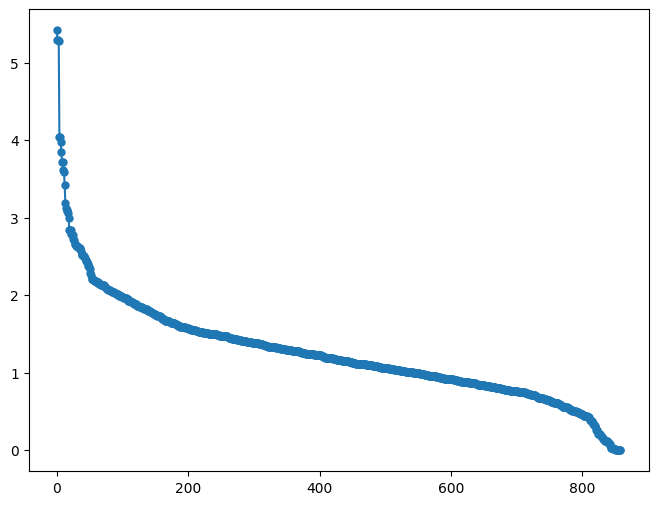

In [30]:
def calculate_k_distance(X,k):
    k_distance = []
    for i in range(len(X)):
        dist = []
        for j in range(len(X)):
            dist.append(np.linalg.norm(X[i,:]-X[j,:]))
        dist.sort()
        k_distance.append(dist[k])
    k_distance.sort(reverse=True)
    return k_distance

k = 3
k_distances = calculate_k_distance(reduced_embeddings_tsne,k)
plt.figure(figsize=(8,6))
plt.plot(range(len(reduced_embeddings_tsne)),k_distances, markersize=5, marker='o', linestyle='-')
plt.show()

###Model Training 
we will train diffrent models to get the best possibile result :
- DBSCAN.
- Kmeans.
- SpectralClustering.

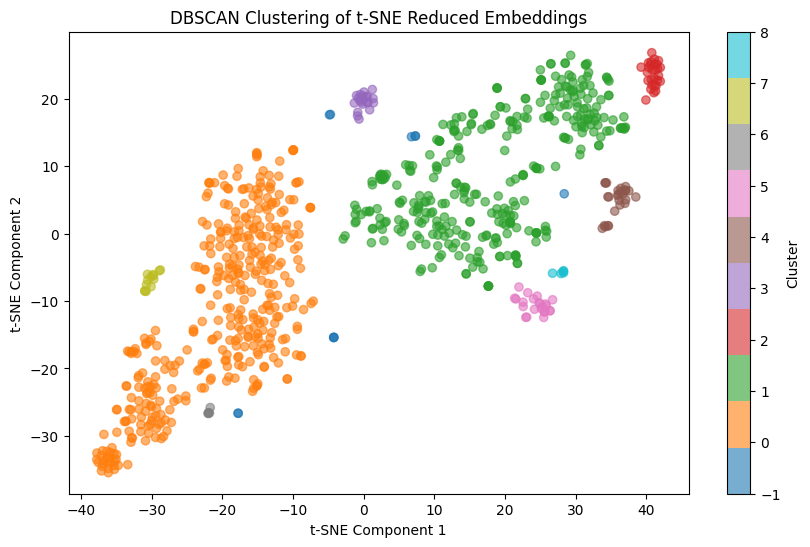

In [31]:

dbscan = DBSCAN(eps=3, min_samples=5)
clusters = dbscan.fit_predict(reduced_embeddings_tsne)

# Plot the DBSCAN Clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=clusters, cmap='tab10', alpha=0.6)
plt.title('DBSCAN Clustering of t-SNE Reduced Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

Calculate best k for Kmeans.
for Kmeans we will fit the model with the combined scaled embeddings with 300 dimentions this improve the model.

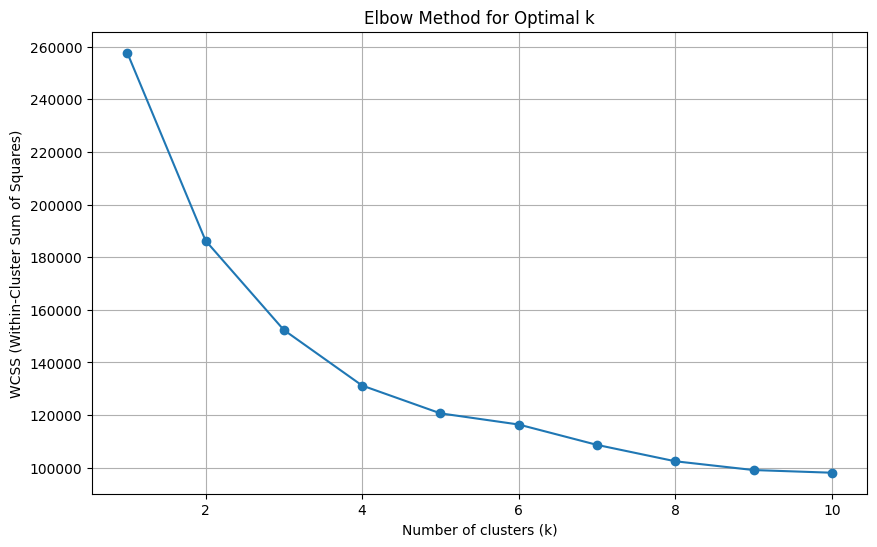

In [32]:

wcss = []
max_k = 10 
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_embeddings)  
    wcss.append(kmeans.inertia_)  

# Step 2: Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid()
plt.show()


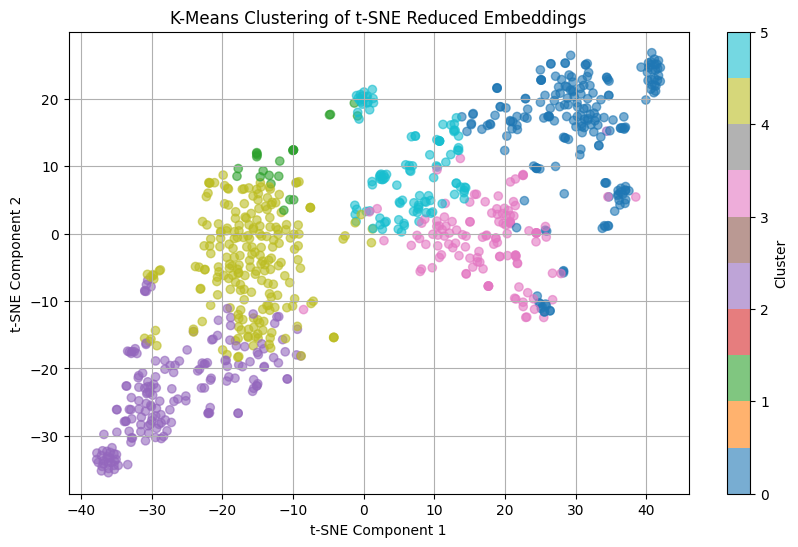

In [33]:
n_clusters = 6  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model and predict clusters
result['cluster'] = kmeans.fit_predict(scaled_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=result['cluster'], cmap='tab10', alpha=0.6)
plt.title('K-Means Clustering of t-SNE Reduced Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

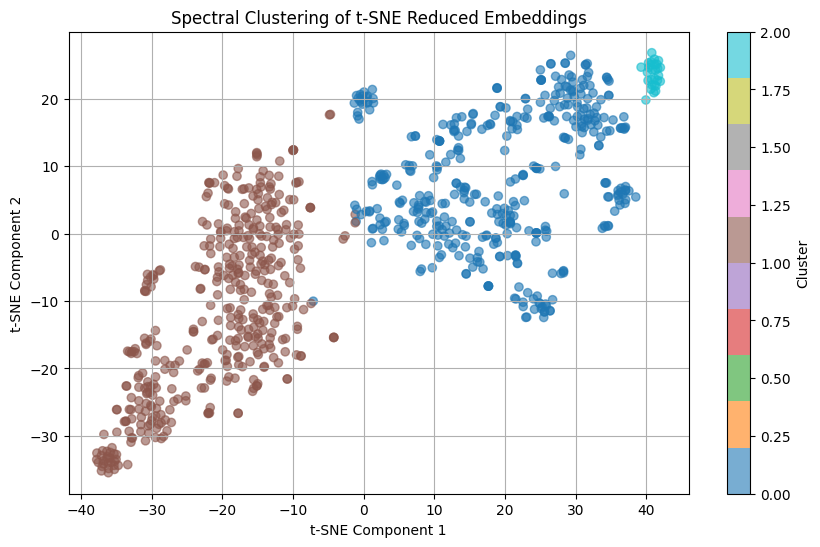

In [34]:

n_clusters = 3  
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
result['spectral_cluster'] = spectral_clustering.fit_predict(scaled_embeddings)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=result['spectral_cluster'], cmap='tab10', alpha=0.6)
plt.title('Spectral Clustering of t-SNE Reduced Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()


## Predicting a New Form and Finding the Nearest Data Point to the Centroid

In this step, we will demonstrate how to predict which cluster a new form belongs to using the same preprocessing and clustering steps we used for the training data. After determining the cluster, we will find the centroid of the predicted cluster and locate the nearest data point to this centroid.


1. **Create Embeddings for the New Form**:
   - Similar to how we generated embeddings for the training data, we need to generate embeddings for the new form. This includes:
     - Generating the embeddings for the form's name, field types, and labels.
     - Concatenating these embeddings into a single 1D vector.

2. **Scale the New Form's Embedding**:
   - To ensure that the new form's embedding is on the same scale as the training data, we apply the same scaling technique that was used during the training phase. This ensures that the features are comparable.

3. **Predict the Cluster**:
   - Once the new form's embedding is prepared and scaled, we use the trained K-Means model to predict which cluster this new form belongs to.

4. **Retrieve the Centroid of the Predicted Cluster**:
   - After predicting the cluster, we get the coordinates of the centroid of the predicted cluster from the K-Means model. This will give us the central point of the cluster in the embedding space.

5. **Find the Nearest Data Point to the Centroid**:
   - Since the centroid is unlikely to be a point where any data point lies exactly, we will use the **NearestNeighbors** model to find the nearest data point to the centroid.
   - This allows us to find a data point that is closest to the centroid in terms of distance in the embedding space.


The new form belongs to cluster: 3


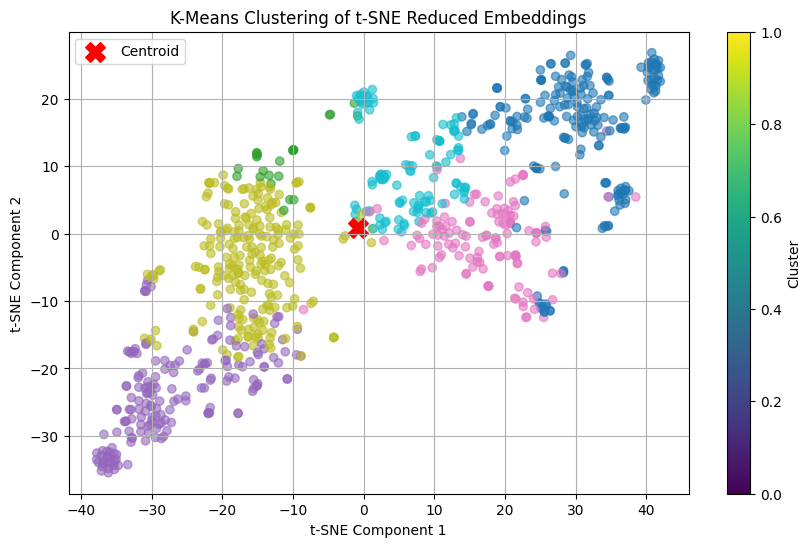

In [41]:
# Example form to predict
new_name = "Kundereklamation"
fieldtypes = ['listselect', 'string', 'string']
labels = ['Vælg kunde', 'Gadenavn', 'Postnr']

# Step 1: Generate embeddings for each component
name_embed = get_embedding(new_name)
field_embed = get_embedding(fieldtypes)
label_embed = get_embedding(labels)

# Step 2: Combine the embeddings into a single 1D embedding (300-dimensional vector)
cembedding = np.concatenate((name_embed, field_embed, label_embed))

# Step 4: Reshape the embedding to a 2D array (1 sample, 300 features)
cembedding = cembedding.reshape(1, -1)

# Step 5: Scale the new embedding using the same scaler fitted on the training data
cembedding_scaled = scaler.fit_transform(cembedding)  # Use transform, not fit_transform, to avoid refitting

# Step 6: Predict the cluster for the new form's embedding
new_cluster = kmeans.predict(cembedding_scaled)[0]  # Predict the cluster for the single sample

# Step 7: Retrieve the centroid of the predicted cluster
centroid_coordinates = kmeans.cluster_centers_[new_cluster]

# Print the results
print(f"The new form belongs to cluster: {new_cluster}")
# print(f"The centroid coordinates of this cluster are: {centroid_coordinates}")
# Step 2: Plot the t-SNE reduced embeddings
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=result['cluster'], cmap='tab10', alpha=0.6)

# Step 3: Plot the centroid of the predicted cluster
# Assuming centroid_coordinates is a 2D point (x, y) for the centroid
plt.scatter(centroid_coordinates[0], centroid_coordinates[1], color='red', marker='X', s=200, label='Centroid')

# Add title, labels, grid, and color bar
plt.title('K-Means Clustering of t-SNE Reduced Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.legend()  # Add legend to indicate that 'X' represents the centroid
plt.grid(True)

# Show the plot
plt.show()

In [46]:

knn = NearestNeighbors(n_neighbors=1)  # We want only the closest neighbor
knn.fit(scaled_embeddings)  # combined_embeddings should be your training data embeddings

# Step 4.2: Find the index of the closest data point to the centroid
distances, indices = knn.kneighbors([centroid_coordinates])

# The `indices` will give you the index of the closest data point in the training set
closest_data_point = result.iloc[indices[0][0]]

# Print the results

print(f"The closest data point to the centroid is: {closest_data_point['name']}")
for item in closest_data_point['fieldlabel']:
    print(item)

The closest data point to the centroid is: EHS - Liste med værnemidler/PPE
Andre navne
Navn på værnemiddel/PPE
Beskyttelseskategori
Overholder standard
Bruges ved
Brugsanvisning
Særlig opmærksomhed!
Upload datablad
Leveres af:
Producent:
Benyttes sammen med
Sidst evalueret
Tilbehør
Foto
